In [1]:

import os
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from joblib import dump, load
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score
from sklearn.model_selection import GridSearchCV





In [2]:
import hopsworks

# Get the API key from GitHub Secrets
HOPSWORKS_API_KEY = os.getenv('HOPSWORKS_API_KEY')

#with open('hopsworks-api-key.txt', 'r') as file:
#   os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()

In [3]:
project = hopsworks.login(project="ScalableMLandDeepLcourse")
fs = project.get_feature_store()

2025-01-08 10:24:21,794 INFO: Initializing external client
2025-01-08 10:24:21,795 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-08 10:24:23,188 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1170582


## 3.Write a training pipeline

### 3.1 Get datas from features groups

In [4]:
# Load the Feature Groups for air quality and weather data
trafic_fg = fs.get_feature_group(name="stockholm_traffic", version=1)
weather_fg = fs.get_feature_group(name="stockholm_weather_holiday", version=1)

# Read the data from both feature groups
trafic_df = trafic_fg.read()
weather_df = weather_fg.read()


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (13.23s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.66s) 


## Data Filtering

### Delete not exploitable datas

In [5]:
cutoff_date = pd.Timestamp("2024-12-19 09:00:00+00:00")
trafic_df = trafic_df[trafic_df["date"] >= cutoff_date]

In [6]:
weather_df = weather_df[weather_df["date"] >= cutoff_date]

### One hot vector for FRC and coordinates

In [7]:

# Label Encoding
label_encoder_FRC = LabelEncoder()

trafic_df["FRC"] = label_encoder_FRC.fit_transform(trafic_df["frc"])

# Supprimer l'ancienne colonne frc
trafic_df = trafic_df.drop(columns=["frc"])


In [8]:
# Label Encoding
label_encoder_coor = LabelEncoder()

trafic_df["SEG"] = label_encoder_coor.fit_transform(trafic_df["coordinates"])

# Supprimer l'ancienne colonne coordinates
trafic_df

,currentspeed,freeflowspeed,currenttraveltime,freeflowtraveltime,confidence,roadclosure,coordinates,relativespeed,date,FRC,SEG
332,32,32,35,35,1.00,False,LINESTRING (18.055590353453425 59.343962996428...,1.000000,2024-12-19 09:00:00+00:00,3,91
333,13,18,133,96,0.92,False,LINESTRING (18.061118386234426 59.336105451264...,0.722222,2024-12-19 09:00:00+00:00,6,129
334,13,13,104,104,1.00,False,LINESTRING (18.030286393601045 59.340611581406...,1.000000,2024-12-19 09:00:00+00:00,5,1
335,20,20,125,125,1.00,False,LINESTRING (18.038106373985812 59.356495623756...,1.000000,2024-12-19 09:00:00+00:00,6,21
336,26,26,99,99,1.00,False,LINESTRING (18.060517571414948 59.338708520808...,1.000000,2024-12-19 09:00:00+00:00,3,126
...,...,...,...,...,...,...,...,...,...,...,...
75983,13,13,104,104,1.00,False,LINESTRING (18.030286393601045 59.340611581406...,1.000000,2025-01-08 09:00:00+00:00,5,1
75984,12,12,29,29,1.00,False,LINESTRING (18.039281181534562 59.348101653377...,1.000000,2025-01-08 09:00:00+00:00,6,27
75985,13,20,29,19,1.00,False,LINESTRING (18.053853623115884 59.343592841462...,0.650000,2025-01-08 09:00:00+00:00,3,80
75986,37,37,33,33,1.00,False,LINESTRING (18.06716274425088 59.3471266502968...,1.000000,2025-01-08 09:00:00+00:00,1,159


In [9]:
trafic_df = trafic_df.drop(columns=["coordinates"])

### Add the label (the relative speed for the following hour)

In [10]:
trafic_df["relativespeed_h1"] = (
    trafic_df.sort_values("date").groupby("SEG")["relativespeed"].shift(-1)  # Décalage pour +1H dans chaque segment
)


### Join both datas

In [11]:
merged_df = pd.merge(trafic_df, weather_df, on="date", how="inner")

In [12]:
merged_df = merged_df.dropna()

In [13]:
merged_df['heure'] = pd.to_datetime(merged_df['date']).dt.hour

In [14]:
merged_df = merged_df.drop(columns=["date"],axis=1)

In [15]:
merged_df

,currentspeed,freeflowspeed,currenttraveltime,freeflowtraveltime,confidence,roadclosure,relativespeed,FRC,SEG,relativespeed_h1,temperature_2m_max,temperature_2m_min,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,holiday_status,heure
0,32,32,35,35,1.00,False,1.000000,3,91,0.709677,8.226,3.926,0.8,22.680000,232.057388,0,9
1,13,18,133,96,0.92,False,0.722222,6,129,1.000000,8.226,3.926,0.8,22.680000,232.057388,0,9
2,13,13,104,104,1.00,False,1.000000,5,1,0.692308,8.226,3.926,0.8,22.680000,232.057388,0,9
3,20,20,125,125,1.00,False,1.000000,6,21,1.000000,8.226,3.926,0.8,22.680000,232.057388,0,9
4,26,26,99,99,1.00,False,1.000000,3,126,0.600000,8.226,3.926,0.8,22.680000,232.057388,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75486,23,33,23,16,1.00,False,0.696970,2,17,0.787879,2.926,-0.324,1.8,21.599998,192.254135,0,8
75487,20,37,62,33,1.00,False,0.540541,1,159,1.000000,2.926,-0.324,1.8,21.599998,192.254135,0,8
75488,23,23,23,23,1.00,False,1.000000,3,106,1.000000,2.926,-0.324,1.8,21.599998,192.254135,0,8
75489,16,23,26,18,1.00,False,0.695652,2,142,0.541667,2.926,-0.324,1.8,21.599998,192.254135,0,8


In [16]:
merged_df.to_csv("zozo.csv")

### 3.4 Split datas

In [17]:
# Define features and target
X = merged_df.drop(columns=["relativespeed_h1"])
y = merged_df["relativespeed_h1"]

# Undersample rows where relativespeed = 1
class_1 = merged_df[merged_df["relativespeed_h1"] == 1]
class_less_than_1 = merged_df[merged_df["relativespeed_h1"] < 1]


# Adjust the sampling ratio
undersampled_class_1 = class_1.sample(len(class_less_than_1), random_state=42)
balanced_data = pd.concat([undersampled_class_1, class_less_than_1])

# Shuffle the dataset
balanced_data = balanced_data.sample(frac=1, random_state=42)

# Split into features and labels
X_balanced = balanced_data.drop(columns=["relativespeed_h1"])
y_balanced = balanced_data["relativespeed_h1"]


# Split into training validating and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)



### 3.5 Train the model with the training split


In [18]:

# # Définir les hyperparamètres à tester
param_grid = {
    'n_estimators': [100, 200, 300],               # Nombre d'arbres
    'max_depth': [3, 5, 7, 9],                    # Profondeur maximale des arbres
    'learning_rate': [0.01, 0.05, 0.1, 0.2],      # Taux d'apprentissage
    'subsample': [0.6, 0.8, 0.9, 1.0],            # Fraction des données utilisées pour chaque arbre
}

# Configurer GridSearchCV avec R^2 comme scoring
grid_search = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='r2',  # Utiliser R^2 comme métrique
    n_jobs=-1      # Utilise tous les cœurs disponibles pour accélérer
)

# Ajuster le modèle sur les données d'entraînement
grid_search.fit(X_val, y_val)

# Afficher les meilleurs paramètres et le meilleur score
print("Best parameters found: ", grid_search.best_params_)
print("Best R2 : ", grid_search.best_score_)



Best parameters found:  {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best R2 :  0.3255263712503792


In [20]:
# Creating an instance of the XGBoost Regressor
xgb_model = grid_search.best_estimator_


# Fitting the XGBoost Regressor to the training data
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

### 3.6 Infere on the test split and evaluate

In [21]:
# Predicting target values on the test set
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
r2_sco = r2_score(y_test,y_pred_test)

print(f"Train MSE: {train_mse:.2f}")
print(f"Test MSE: {test_mse:.2f}")
print(f"r2 score: {r2_sco:.2f}")

Train MSE: 0.02
Test MSE: 0.02
r2 score: 0.37


In [22]:
# Combiner les labels réels et les prédictions dans un DataFrame
comparison_df = pd.DataFrame({
    "Actual": y_test[:30].values,       # Les 10 premières valeurs réelles
    "Predicted": y_pred_test[:30]      # Les 10 premières prédictions
})

# Afficher les résultats côte à côte
print(comparison_df)

      Actual  Predicted
0   1.000000   0.966821
1   1.000000   0.938026
2   0.666667   0.870048
3   1.000000   0.902357
4   1.000000   0.892807
5   0.740741   0.743396
6   0.677419   0.902292
7   1.000000   0.998475
8   1.000000   0.830859
9   0.764706   0.789839
10  1.000000   0.881558
11  0.718750   0.686648
12  0.566667   0.822306
13  1.000000   0.929127
14  1.000000   0.779565
15  0.684211   0.874415
16  1.000000   0.922547
17  0.571429   0.819019
18  1.000000   0.974193
19  0.861111   0.977222
20  1.000000   0.767184
21  0.642857   0.870489
22  1.000000   0.959775
23  0.588235   0.744305
24  0.800000   0.739959
25  1.000000   0.849734
26  1.000000   0.807782
27  1.000000   0.927886
28  0.625000   0.837168
29  1.000000   0.979158


In [47]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "trafic_pred_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

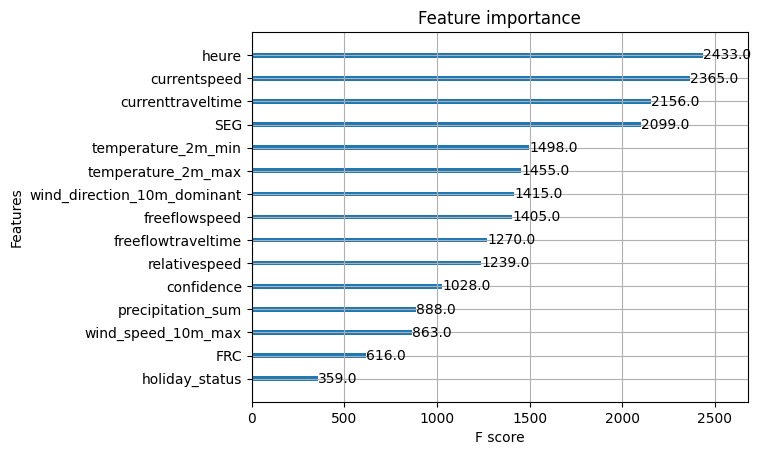

In [48]:
import xgboost as xgb

xgb.plot_importance(xgb_model)

### 3.7 Save the model

In [49]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(X_train)
output_schema = Schema(y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()

In [50]:

# Save the model
dump(xgb_model, model_dir + "/xgboost_model.joblib")




['trafic_pred_model/xgboost_model.joblib']

In [51]:
res_dict = { 
        "MSE_train": str(train_mse),
        "MSE_test": str(test_mse),
        "R2 test" : str(r2_sco)
    }

In [52]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named ''

traffic_model = mr.python.create_model(
    name="trafic_pred_xgboost", 
    metrics= res_dict,
    model_schema=model_schema,
    input_example=X_test.sample().values, 
    description="Traffic Patterns predictor with regression tree",
)

# Saving the model artifacts to the 'dtree_model' directory in the model registry
traffic_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/1577440 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/1577440 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/149 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/1398 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1170582/models/trafic_pred_xgboost/1


Model(name: 'trafic_pred_xgboost', version: 1)